In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable tensorflow debugging logs
import tensorflow as tf
import math
import matplotlib.pyplot as plt
from model import Generator
from utils import Loader, Config
from trainer import LadaGAN
from config import config
from utils import deprocess
%matplotlib inline

In [2]:
loader = Loader()
loader.download('celeba_64')
model_dir = './celeba_64'

In [3]:
conf = Config(config, model_dir)

Config ./celeba_64/config.json loaded


In [4]:
noise = tf.random.normal([conf.batch_size, conf.noise_dim])
generator = Generator(
    img_size=conf.img_size, model_dim=conf.g_dim, 
    heads=conf.g_heads, mlp_dim=conf.g_mlp
)
gen_batch = generator(noise)
generator.summary()
print('G output shape:', gen_batch[0].shape)

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (128, 64, 1024)           8388608   
                                                                 
 positional_embedding (Posi  multiple                  65536     
 tionalEmbedding)                                                
                                                                 
 sm_ladaformer (SMLadaforme  multiple                  9715204   
 r)                                                              
                                                                 
 conv2d (Conv2D)             multiple                  590080    
                                                                 
 positional_embedding_1 (Po  multiple                  65536     
 sitionalEmbedding)                                              
                                                         

In [5]:
gan =  LadaGAN(
    generator=generator, discriminator=None, 
    conf=conf
)
gan.restore_generator(model_dir)

Best checkpoint restored from ./celeba_64/best-training-checkpoints/ckpt-72192000


In [6]:
resolutions = 3
heads = 4
direct = './'
n = 16

noise_seed = tf.random.normal(
    [n, conf.noise_dim], seed=conf.test_seed
)

In [7]:
def get_map(resolution, head):
    h = head
    r = resolution
    map_size = int(math.sqrt(maps[r][0][0].shape[0])) # get map high and width 
    b = maps[r][:, h].shape[0]
    reshaped_maps = tf.reshape(maps[r][:, h], [b, map_size, map_size, 1])
    return reshaped_maps

In [8]:
predictions, maps = gan.ema_generator(noise_seed, training=False)
predictions = tf.clip_by_value(deprocess(predictions), 0.0, 255.0)
predictions = tf.cast(predictions, tf.uint8).numpy()

h = 1
maps32 = get_map(2, h)
maps16 = get_map(1, h)
maps8 = get_map(0, h)

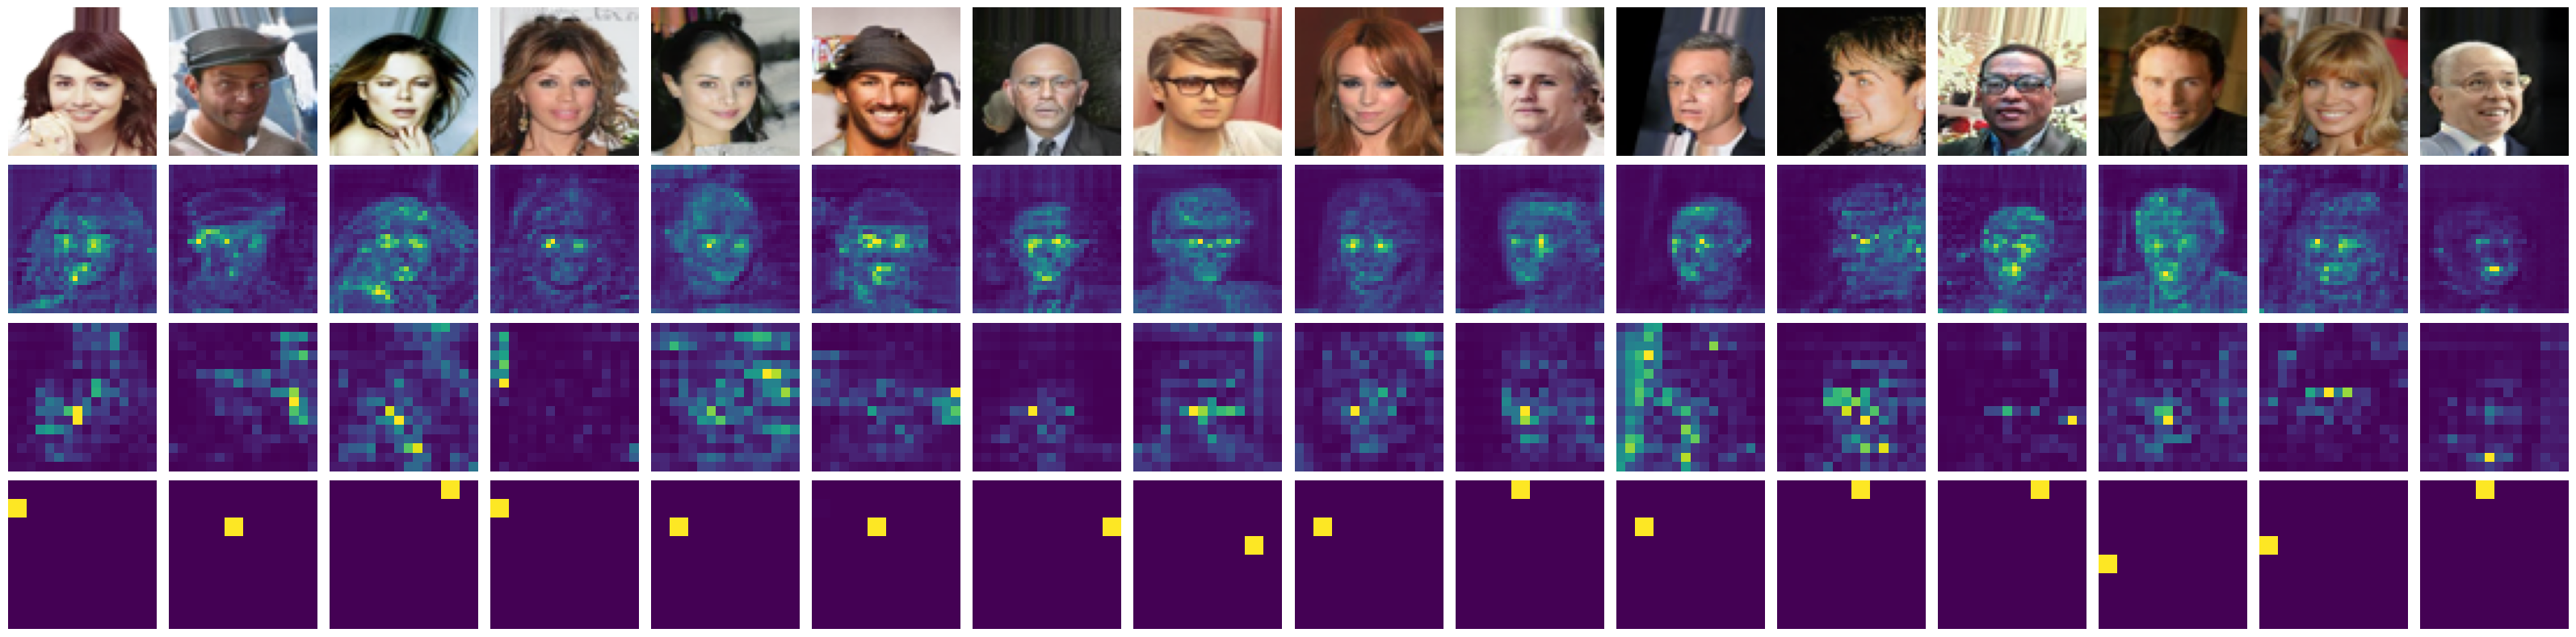

In [9]:
# Create a figure with multiple subplots
fig, axes = plt.subplots(4, n, figsize=(n*2, 4*2))

# Plot the images in the first row
for i in range(n):
    axes[0, i].imshow(predictions[i])
    axes[0, i].axis('off')

# Plot maps32 in the second row
for i in range(n):
    axes[1, i].imshow(maps32[i, :, :, 0])
    axes[1, i].axis('off')

# Plot maps16 in the third row
for i in range(n):
    axes[2, i].imshow(maps16[i, :, :, 0])
    axes[2, i].axis('off')

# Plot maps8 in the fourth row
for i in range(n):
    axes[3, i].imshow(maps8[i, :, :, 0])
    axes[3, i].axis('off')

# Remove the titles
for ax in axes.ravel():
    ax.set_title("")

# Display the plot
plt.tight_layout()
plt.show()